# Song Popularity

## Load the Data

Data can be found here: https://www.kaggle.com/datasets/tonygordonjr/spotify-dataset-2023?select=spotify_data_12_20_2023.csv

In [193]:
# Load the data
import pandas as pd
import numpy as np
import ast

# Note that the converters section makes it take literally twice as long to load
data: pd.DataFrame = pd.read_csv(
    "spotify_data_12_20_2023.csv",
    converters={
        "artists": ast.literal_eval,  # Makes it so that artists becomes an actual list instead of a string representation of one
        # "artist_genres": ast.literal_eval,
    },
    dtype={
        "album_name": "string",
        "name": "string",
        "track_name": "string",
        "explicit": "boolean",
        "album_type": "category",
        "genre_0": "string",
        "genre_1": "string",
        "genre_2": "string",
        "genre_3": "string",
        "genre_4": "string",
    },
    parse_dates=["release_date"],
)

if "duration_ms" in data.columns and "duration_sec" in data.columns:
    data.drop(columns=["duration_sec"], inplace=True)

# TODO: Drop rows SELECTIVELY
# print(data.isna().sum())
hardcoded_drop_columns: list[str] = [
    "rn",
    "uri",
    "track_number",
    "analysis_url",
    "track_href",
    "album_id",
    "artist_0",
    "artist_1",
    "artist_2",
    "artist_3",
    "artist_4",
    "artist_id",
    "type",
    "total_tracks",
]
data.drop(
    columns=[c for c in hardcoded_drop_columns if c in data.columns], inplace=True
)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

data.dropna(
    axis=0,
    subset=[
        "track_popularity",
        "tempo",
        "acousticness",
        "danceability",
        "release_year",
    ],
    inplace=True,
)
# print(data.isna().sum())


# BUG: DtypeWarning: Columns (25,26,44) have mixed types
# print(data.columns)


# Professor suggestions:
####
# Split it into "model" trees
# Figure out if there are bounds where it is extremely accurate
# Find a cutoff

# Pick a random 10k instead of 300k
# Calculate a balanced accuracy
# The balanced accuracy as a function of split is a curve that peaks somewhere
# If it is smooth then you can do a binary search
####

# TODO: Replace columns like genre with numerical values

# TODO: Capitalizeed letter after apostrophe in track titles

# TODO: Take a bit out as a test set

In [194]:
# Tokenize genres
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

if "genres" not in data.columns:
    data["genres"] = (
        data[["genre_0", "genre_1", "genre_2", "genre_3", "genre_4"]]
        # data[["genre_0", "genre_1"]]
        .fillna("")
        .agg(" ".join, axis=1)
    )

    data.drop(
        columns=["genre_0", "genre_1", "genre_2", "genre_3", "genre_4"], inplace=True
    )

tfidf = TfidfVectorizer(max_features=1000)
tfidf_vectors = tfidf.fit_transform(data["genres"])
# data["genre_vector"] = list(np.asarray(tfidf_vectors.todense()))
# tfidf_df = pd.DataFrame(
#     tfidf_vectors.todense(),
#     columns=[f"genre_tfidf_{genre}" for genre in tfidf.get_feature_names_out()],
#     index=data.index,
# )

# data = pd.concat([data, tfidf_df], axis=1)
svd = TruncatedSVD(n_components=10, random_state=2)
decomposed_tfidf = svd.fit_transform(tfidf_vectors)

for i in range(decomposed_tfidf.shape[1]):
    data[f"genre_vector_{i}"] = decomposed_tfidf[:, i]

In [195]:
assert data is not None

x = data.select_dtypes(include="number", exclude="int64").drop(
    columns=["track_popularity"]
)

# TODO: Train the track_popularity number
y = (data["track_popularity"] > 50).astype(int)

# Show the distribution of the track_popularity on the above threshold
print(y.value_counts(normalize=True))

track_popularity
0    0.964604
1    0.035396
Name: proportion, dtype: float64


## Decision Trees

In [196]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    root_mean_squared_error,
    roc_auc_score,
    accuracy_score,
)
import matplotlib.pyplot as plt

assert data is not None

# No MAX_DEPTH leads to higher accuracy (0.6361 -> 0.9147), but it has a lower AUC (0.7587 -> 5767)
# My guess is, overfitting with no max depth.
MAX_DEPTH: int | None = 10
dt = DecisionTreeClassifier(
    max_depth=MAX_DEPTH,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=x.size,
    max_features="sqrt",
    class_weight="balanced",  # Make the 1's have more hold
)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=x.size
)
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)
y_pred_proba = dt.predict_proba(x_test)[:, 1]  # type: ignore

accuracy = accuracy_score(y_test, y_pred)
area_under_curve = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:0.4f}")
print(f"Area Under Curve: {area_under_curve:0.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):0.4f}")


FEATURE = "loudness"
assert FEATURE in x.columns

# Random sample the data for visualization
SAMPLE_SIZE = min(3000, len(x_test))
sample_index = np.random.choice(len(x_test), size=SAMPLE_SIZE, replace=False)

x_sample = x_test.iloc[sample_index]
y_sample = y_test.iloc[sample_index]
y_pred_sample = y_pred[sample_index]
print(y_pred_sample)

Accuracy: 0.8091
Area Under Curve: 0.8887
RMSE: 0.4369
[0 0 0 ... 0 1 0]


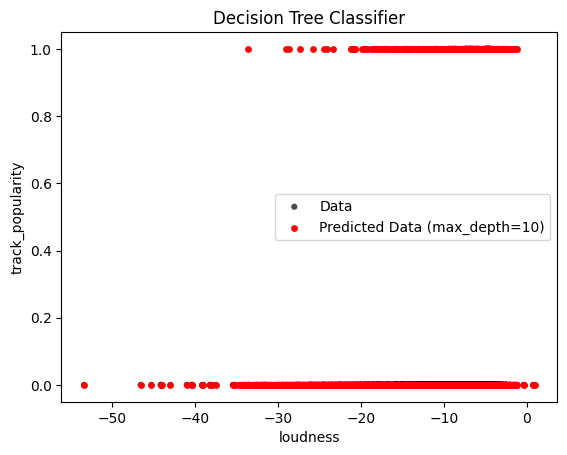

In [184]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#plot-the-results
plt.figure()
plt.scatter(
    x_sample[FEATURE],
    y_sample,
    s=20,
    alpha=0.7,
    edgecolor="none",
    c="black",
    label="Data",
)
plt.scatter(
    x_sample[FEATURE],
    y_pred_sample,
    color="red",
    s=15,
    alpha=1,
    label=f"Predicted Data (max_depth={MAX_DEPTH})",
)
# sns.pairplot(data, vars=x.columns, y_vars="track_popularity", hue="track_popularity")
# plt.plot(x_test[FEATURE], y_pred, color="red", label=f"max_depth={MAX_DEPTH}", linewidth=2)
plt.xlabel(FEATURE)
plt.ylabel("track_popularity")
plt.title("Decision Tree Classifier")
plt.legend()
plt.show()

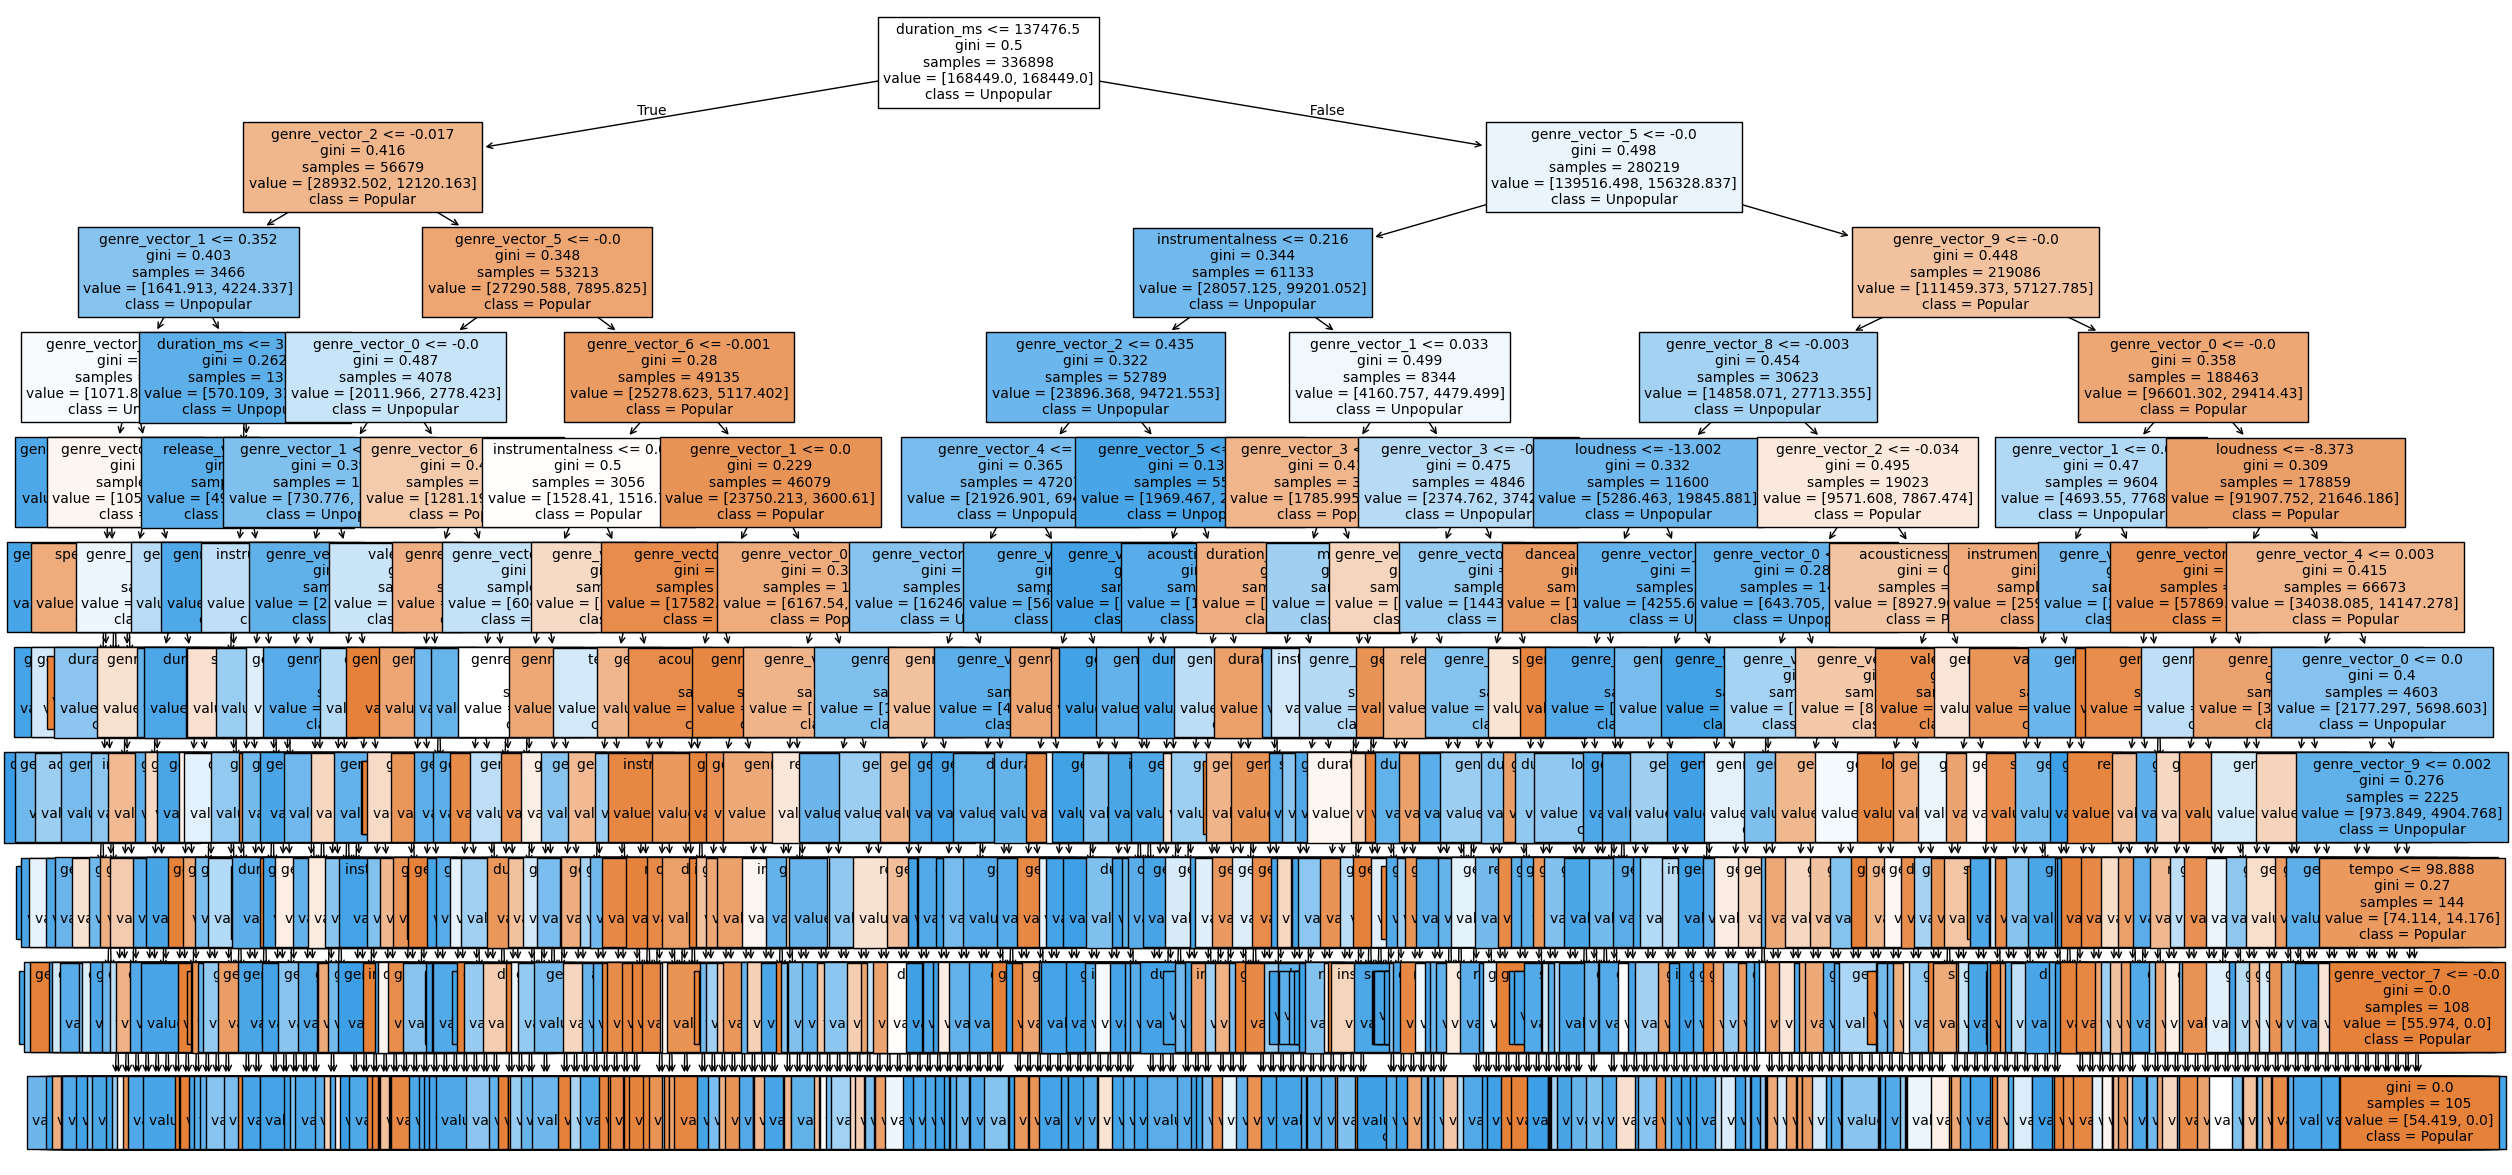

In [197]:
from sklearn.tree import plot_tree, export_graphviz

plt.figure(figsize=(30, 15))
# TODO: I'm not sure the order in which Popular/Unpopular should be
# They are DIFFERENT between the export and this one
plot_tree(
    dt,
    feature_names=x.columns.tolist(),
    class_names=["Popular", "Unpopular"],
    fontsize=10,
    filled=True,
)
plt.show()

EXPORT_DT = False
if EXPORT_DT:
    export_graphviz(
        dt,
        out_file="decision_tree.dot",
        feature_names=x.columns.tolist(),
        class_names=["Unpopular", "Popular"],
        filled=True,
    )


In [198]:
# TODO: Delete OR refactor
from sklearn.feature_extraction.text import TfidfVectorizer

# This was just some test code to see how the model is doing with a different, more modern dataset
# https://www.kaggle.com/datasets/solomonameh/spotify-music-dataset?select=high_popularity_spotify_data.csv
temp_df = pd.read_csv(
    "high_popularity_spotify_data.csv",
    dtype={
        "track_popularity": "float",
        "duration_ms": "float",
        "mode": "float",
        "time_signature": "float",
        "key": "float",
    },
)

if "genres" not in temp_df.columns:
    temp_df["genres"] = (
        temp_df[["playlist_genre", "playlist_subgenre"]]
        .fillna("")
        .agg(" ".join, axis=1)
    )

    temp_df.drop(columns=["playlist_genre", "playlist_subgenre"], inplace=True)

combined = pd.concat([data["genres"], temp_df["genres"]])
# tfidf.fit(combined)
temp_tfidf_vectors = tfidf.transform(temp_df["genres"])

temp_decomposed_tfidf = svd.transform(temp_tfidf_vectors)

for i in range(temp_decomposed_tfidf.shape[1]):
    temp_df[f"genre_vector_{i}"] = temp_decomposed_tfidf[:, i]

# Map all the columns from another dataset to this one
column_mapping = {
    "track_id": "track_id",
    "track_name": "track_name",
    "track_album_name": "album_name",
    "track_album_id": "album_id",
    "track_popularity": "track_popularity",
    "track_album_release_date": "release_date",
    "energy": "energy",
    "tempo": "tempo",
    "danceability": "danceability",
    "loudness": "loudness",
    "liveness": "liveness",
    "valence": "valence",
    "speechiness": "speechiness",
    "acousticness": "acousticness",
    "instrumentalness": "instrumentalness",
    "mode": "mode",
    "key": "key",
    "time_signature": "time_signature",
    "duration_ms": "duration_ms",
    "genres": "genres",
}
for i in range(1, 10):
    column_mapping[f"genre_vector_{i}"] = f"genre_vector_{i}"
    
temp_df = temp_df.rename(columns=column_mapping)[list(column_mapping.values())]

if "release_date" in temp_df.columns:
    # Get release_year from release_date
    temp_df["release_year"] = (
        temp_df["release_date"].astype(str).str.extract(r"(\d{4})").astype(float)
    )

# Add missing columns as nan
for data_column in data.columns:
    if data_column not in temp_df.columns:
        temp_df[data_column] = np.nan


# Only keep data.columns values
temp_df = temp_df[data.columns]
temp_df.replace([np.inf, -np.inf], np.nan, inplace=True)

temp_df.drop(
    columns=[c for c in hardcoded_drop_columns if c in temp_df.columns], inplace=True
)

temp_df.drop(
    columns=[
        "album_popularity",
        "album_type",
        "artists",
        "label",
        "artist_genres",
        "artist_popularity",
        "followers",
        "name",
        "explicit",
        "release_month",
    ],
    inplace=True,
)

temp_df.dropna(
    axis=0,
    subset=[
        "track_popularity",
        "tempo",
        "acousticness",
        "danceability",
        "release_year",
    ],
    inplace=True,
)
temp_df.head()

,album_name,release_date,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,...,genre_vector_0,genre_vector_1,genre_vector_2,genre_vector_3,genre_vector_4,genre_vector_5,genre_vector_6,genre_vector_7,genre_vector_8,genre_vector_9
0,Die With A Smile,2024-08-16,2plbrEY59IikOBgBGLjaoe,Die With A Smile,0.3080,0.521,251668.0,0.592,0.0000,6.0,...,NaN,0.693137,0.63135,-0.169865,-0.034135,-0.018321,-0.002917,-0.059403,0.024553,-0.000062
1,HIT ME HARD AND SOFT,2024-05-17,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,0.2000,0.747,210373.0,0.507,0.0608,2.0,...,NaN,0.693137,0.63135,-0.169865,-0.034135,-0.018321,-0.002917,-0.059403,0.024553,-0.000062
2,The Secret of Us (Deluxe),2024-10-18,7ne4VBA60CxGM75vw0EYad,That’s So True,0.2140,0.554,166300.0,0.808,0.0000,1.0,...,NaN,0.693137,0.63135,-0.169865,-0.034135,-0.018321,-0.002917,-0.059403,0.024553,-0.000062
3,Short n' Sweet,2024-08-23,1d7Ptw3qYcfpdLNL5REhtJ,Taste,0.0939,0.670,157280.0,0.910,0.0000,0.0,...,NaN,0.693137,0.63135,-0.169865,-0.034135,-0.018321,-0.002917,-0.059403,0.024553,-0.000062
4,APT.,2024-10-18,5vNRhkKd0yEAg8suGBpjeY,APT.,0.0283,0.777,169917.0,0.783,0.0000,0.0,...,NaN,0.693137,0.63135,-0.169865,-0.034135,-0.018321,-0.002917,-0.059403,0.024553,-0.000062


In [199]:
x_temp = temp_df.select_dtypes(include="number", exclude="int64").drop(
    columns=["track_popularity"]
)

# TODO: Train the track_popularity number
y_temp = (temp_df["track_popularity"] > 50).astype(int)
# dt.predict(x_temp)
results = dt.predict(x_temp)
# temp_df.head()
# x_temp.head()
print(np.unique_counts(results))

UniqueCountsResult(values=array([0, 1]), counts=array([ 518, 1168]))


<Figure size 640x480 with 0 Axes>

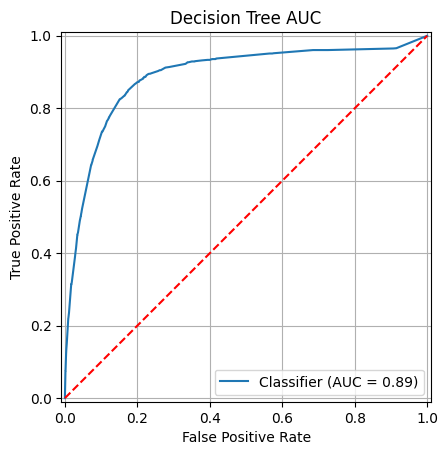

In [200]:
# Plot the decision tree AUC
from sklearn.metrics import RocCurveDisplay

# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# A good decision tree will have a HIGH AUC (0.8+), high TPR with low FPR.
plt.figure()
rcd: RocCurveDisplay = RocCurveDisplay.from_predictions(y_test, y_pred_proba)
# rcd.plot()
# plt.plot(fpr, tpr, label=f"Decision Tree (AUC={area_under_curve:0.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree AUC")
plt.grid(True)
plt.legend()
plt.show()

## Naive Bayes

Documentation: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

assert x is not None
assert y is not None

clf = BernoulliNB()

clf.fit(x, y)
# TODO: Not implemented
clf.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0], shape=(37434,))